In [1]:
import scvelo as scv
import dynamo as dyn
import numpy as np
from anndata import AnnData
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from scipy.cluster.hierarchy import fcluster,leaders
from sklearn.decomposition import PCA
from scipy.linalg import inv
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
from scipy.sparse import csr_matrix,issparse
import pandas as pd
import seaborn as sns

import argparse
import random

import scipy.sparse as sp
import scipy.sparse.csgraph
import sklearn.linear_model as sklm
import sklearn.metrics as skm
import sklearn.model_selection as skms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, IterableDataset, get_worker_info

CHECKPOINT_PREFIX = "g2g"

import sys
sys.path.append('..')

method = ''
from utils.g2g_model_Fisher import *
from utils.utils import *
from utils.RKHS import *

In [2]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())

2.4.0
11.8
True
1
0


In [3]:
data_path = 'data/'
data_name = 'DG_bin'

adata0 = scv.read(data_path+data_name+'.h5ad', cache=True)

# set the parameters
[k_nei, K, L] = [10, 2, 10]
# metric = 'minkowski'
metric = 'euclidean'
# metric = 'cosine'
# metric = 'correlation'
norm = 'none'
# norm = 'standard'
# norm = 'minmax'

result_path = 'results/'+data_name+','+norm+','+metric+','+method+','+str([k_nei,K,L])+'/'
figure_path = 'figures/'
cmap = plt.colormaps['Spectral_r']

In [4]:
#-------data preprocessing
adata=adata0.copy()
scv.pp.neighbors(adata, n_neighbors=k_nei)
scv.pp.pca(adata,n_comps=50)
scv.pp.moments(adata, n_pcs=50, n_neighbors=k_nei)

computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [5]:
gene_arr = adata.var.index.values
X_pca = adata.obsm['X_pca']
X_umap = adata.obsm['X_umap']
# cell_vpt = adata.obs['velocity_pseudotime'].values#adata0.obs['latent_time'].values#
cell_vpt = adata.obs['palantir_pseudotime']
Xs = adata.layers['Ms']#adata.X.A#
velo0 = np.array(adata.layers['velocity'])
velo_g = np.zeros(velo0.shape)
velo_g[:,adata.var['velocity_genes']] = velo0[:,adata.var['velocity_genes']]
# velo_pca = velo_g@adata.varm['PCs']
velo_pca = adata.obsm['velocity_pca']

if norm=='standard':
    Xs_mean = np.mean(Xs,axis=0)
    Xs_std = np.std(Xs,axis=0)
    X = (Xs-Xs_mean)/Xs_std
    velo = velo_g/Xs_std
elif norm=='minmax':
    Xs_max = np.max(Xs,axis=0)
    Xs_min = np.min(Xs,axis=0)
    X = (Xs-Xs_min)/Xs_max
    velo = velo_g/Xs_max
else:
    X = Xs
#     velo = velo_g
    velo = velo_pca@adata.varm['PCs'].T

In [6]:
row = np.array([np.ones((k_nei,))*i for i in range(adata.shape[0])]).flatten()
col = adata.uns['neighbors']['indices'].flatten()
w_val = np.array([np.linalg.norm(X_pca[int(i),:]-X_pca[int(j),:]) for i,j in zip(row,col)])
adj_val = np.ones(col.shape)
A_mat = csr_matrix((adj_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))
W_mat = csr_matrix((w_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))

In [7]:
cell_nei = np.load(result_path+'cell_nei.npy')
nei_w = np.load(result_path+'nei_w.npy')

def smooth_func(X_val,cell_nei=cell_nei,nei_w=nei_w):
    X_s=X_val.copy()
    for ci in range(len(X_val)):
        X_s[ci]=np.dot(X_val[cell_nei[ci,:]],nei_w[ci,:])
    return X_s

In [8]:
encoder = torch.load(result_path+'encoder.pt')

In [9]:
mu, sigma = encoder(torch.tensor(X))
mu_learned = mu.detach().numpy()
sigma_learned = sigma.detach().numpy()
latent_z = np.hstack((mu_learned,sigma_learned))

Fisher_g=np.zeros((X.shape[0],L*2,L*2))
for i in range(X.shape[0]):
    for j in range(L):
        Fisher_g[i,j,j]=1/sigma_learned[i,j]**2
        Fisher_g[i,L+j,L+j]=2/sigma_learned[i,j]**2

In [10]:
crc = np.load(result_path+'crc.npy')
crc_eu = np.load(result_path+'crc_eu.npy')
crc_smooth = np.load(result_path+'crc_smooth.npy')

In [11]:
xsgn = -1
X_plt = xsgn*X_pca[:,0]
Y_plt = X_pca[:,1]
X_min = np.min(X_plt)
X_max = np.max(X_plt)
Y_min = np.min(Y_plt)
Y_max = np.max(Y_plt)
X_len = (X_max-X_min)/5
Y_len = (Y_max-Y_min)/5
wid = min(X_len,Y_len)/30
X_ori = X_min
Y_ori = Y_min

In [12]:
import seaborn as sns

palette1 = sns.color_palette('bright')
palette2 = sns.color_palette('pastel')
c1 = tuple((np.array(palette1[0])+np.array(palette1[-1]))/2)
c2 = tuple((np.array(palette2[0])+np.array(palette2[-1]))/2)

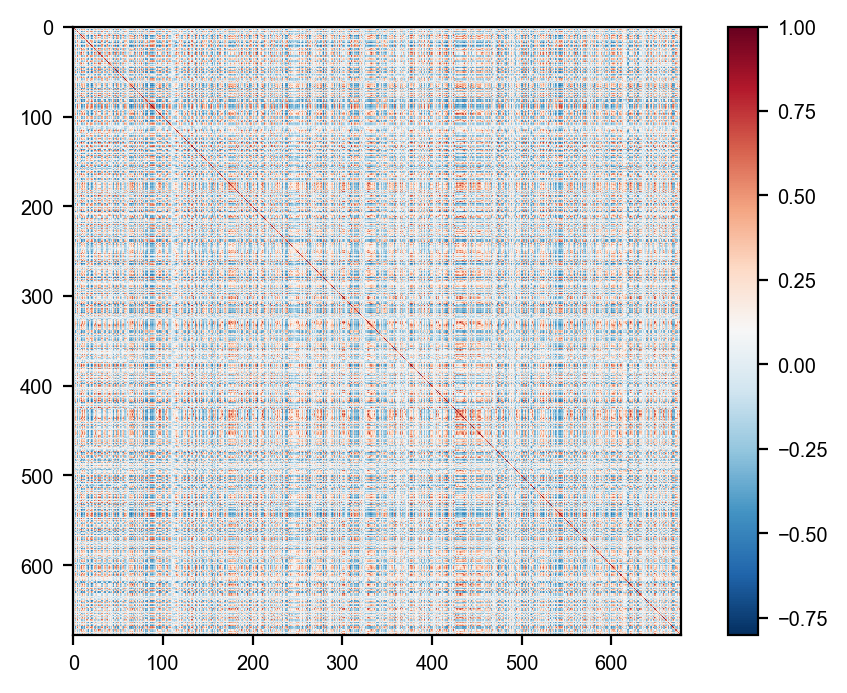

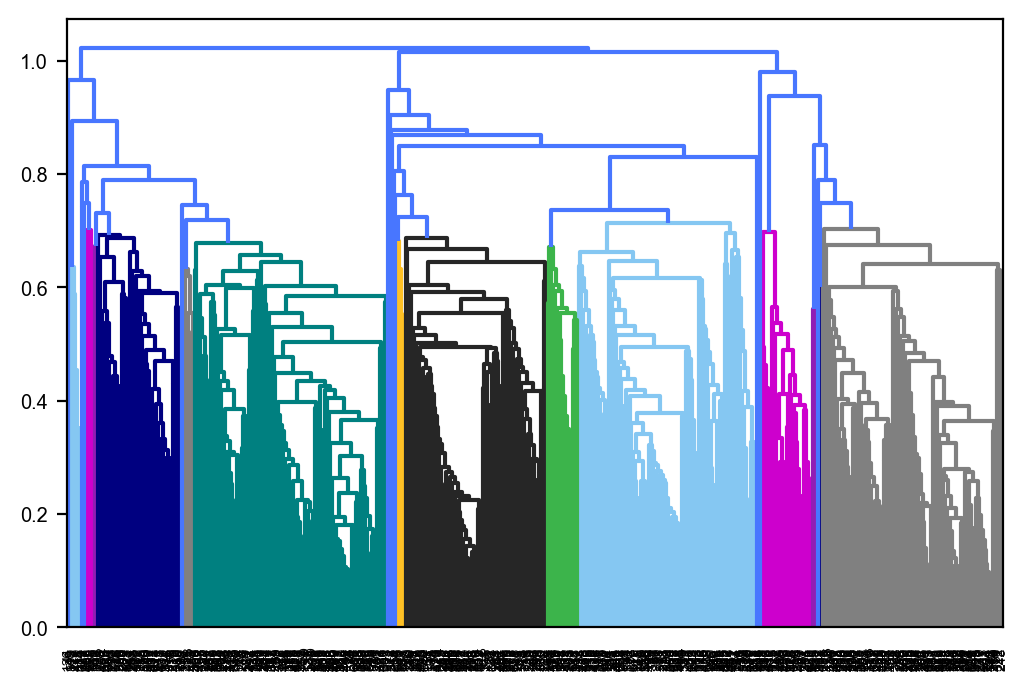

In [13]:
Xs=adata.layers['Ms']#adata.X.A#
Xu=adata.layers['Mu']
scaler=StandardScaler()
#scaler=MinMaxScaler()
X=scaler.fit_transform(Xs)

X_corr=np.corrcoef(X, rowvar=False)
plt.imshow(X_corr)
plt.colorbar()
plt.show()

Z=linkage((1-X_corr)[np.triu_indices(X_corr.shape[0],k=1)],method='weighted')#method='weighted')
dg=dendrogram(Z)
X_re= X[:,dg['leaves']]#X_re reorder X by clustering

X_corr_re=np.corrcoef(X_re, rowvar=False)
plt.show()

In [14]:
td = 0.99
T = fcluster(Z, t=td, criterion='distance')
T_re = T[dg['leaves']]

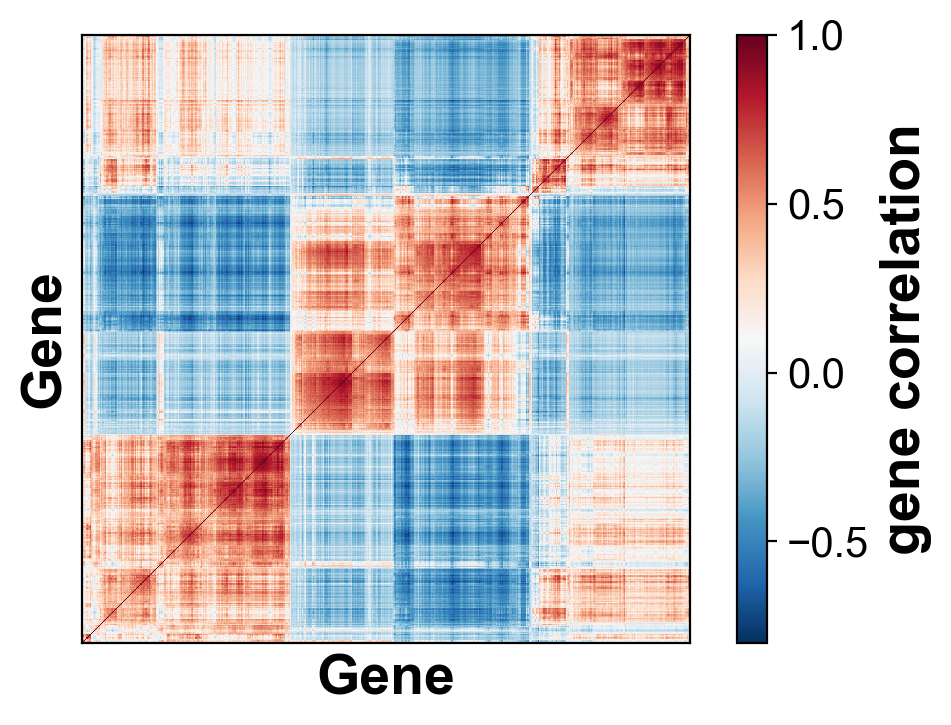

In [15]:
plt.imshow(X_corr_re, aspect='auto', cmap='RdBu_r', interpolation='nearest',origin='lower')
ax = plt.gca()
ax.set_aspect('equal','box')

plt.xlabel('Gene',fontsize=20,fontweight='bold')
plt.ylabel('Gene',fontsize=20,fontweight='bold')
plt.xticks([])
plt.yticks([])

clb = plt.colorbar()
clb.ax.set_ylabel('gene correlation',fontsize=20,weight='bold')
clb.ax.tick_params(axis='y', labelsize=15)

plt.savefig(figure_path+'3f.png',dpi=600,bbox_inches='tight')
plt.show()

In [16]:
# eigen gene is the value of first principal component of each community
def eigen_gene(X_re,T_re):#return the weights of each gene in correponding eigen gene
    eigen_X_w1=[]
    eigen_X_w2=[]
    for i in np.unique(T_re):
        pca=PCA(n_components=10).fit(X_re[:,T_re==i])
        print(pca.explained_variance_ratio_)
        pc1=pca.transform(X_re[:,T_re==i])[:,0]
        pc2=pca.transform(X_re[:,T_re==i])[:,1]
        eigen_X_w1.append(pca.components_[0,:])
        eigen_X_w2.append(pca.components_[1,:])
#         eigen_gene_size.append(np.where(T_re==i)[0].shape[0])
    return eigen_X_w1,eigen_X_w2

In [17]:
eigen_X_w1,eigen_X_w2=eigen_gene(X_re,T_re)
eigen_dim=len(np.unique(T_re))
print(eigen_dim)

[0.45576054 0.08021189 0.04887784 0.02409572 0.01390588 0.01119706
 0.00938591 0.00884213 0.00747471 0.00654662]
[0.4247188  0.13492689 0.03459415 0.01586646 0.01163517 0.00876098
 0.00789989 0.00573286 0.00474056 0.00463042]
[0.46514782 0.11035526 0.07566856 0.0273664  0.01684745 0.01357958
 0.00940538 0.00789128 0.00731952 0.00666159]
3


In [18]:
#---------eigen gene of each single cell----------------
cell_eigen_X1=np.zeros((X_re.shape[0],eigen_dim))
cell_eigen_X2=np.zeros((X_re.shape[0],eigen_dim))
for j in range(X_re.shape[0]):
    for k in range(len(eigen_X_w1)):
        cell_eigen_X1[j,k]=np.dot(eigen_X_w1[k],X_re[j,T_re==k+1])
        cell_eigen_X2[j,k]=np.dot(eigen_X_w2[k],X_re[j,T_re==k+1])

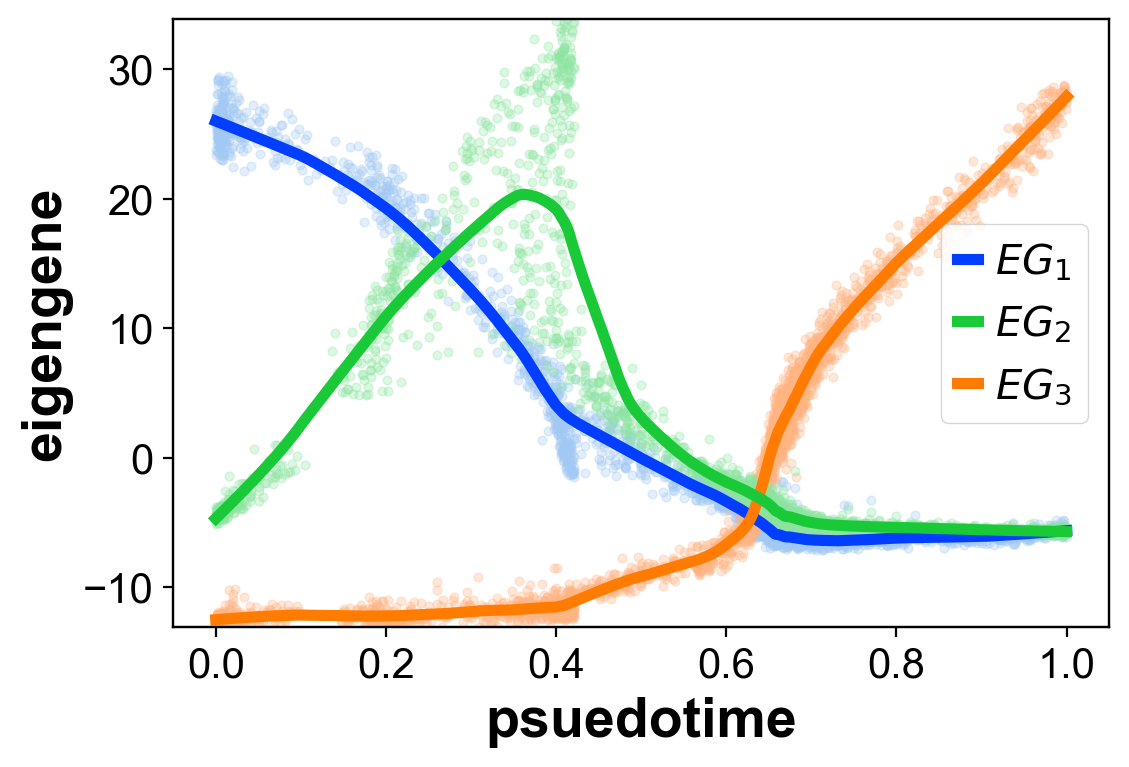

In [19]:
alpha = 0.3
frac = 0.1
e1,e2,e3 = 0,1,2

# plt.figure(dpi=600,bbox_inches='tight')
mask1,x_ls1,y_ls1 = kde_lowess(cell_vpt,cell_eigen_X1[:,e1],frac=frac)
plt.scatter(cell_vpt[mask1],cell_eigen_X1[mask1,e1],s=10,c=palette2[0],alpha=alpha)
mask2,x_ls2,y_ls2 = kde_lowess(cell_vpt,cell_eigen_X1[:,e2],frac=frac)
plt.scatter(cell_vpt[mask2],cell_eigen_X1[mask2,e2],s=10,c=palette2[1],alpha=alpha)
mask3,x_ls3,y_ls3 = kde_lowess(cell_vpt,cell_eigen_X1[:,e3],frac=frac)
plt.scatter(cell_vpt[mask3],cell_eigen_X1[mask3,e3],s=10,c=palette2[2],alpha=alpha)
plt.xlabel('psuedotime',fontsize=20,weight='bold')
plt.ylabel('eigengene',fontsize=20,weight='bold')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ymin1 = min(np.concatenate((cell_eigen_X1[mask1,e1],cell_eigen_X1[mask2,e2],cell_eigen_X1[mask3,e3])))
ymax1 = max(np.concatenate((cell_eigen_X1[mask1,e1],cell_eigen_X1[mask2,e2],cell_eigen_X1[mask3,e3])))
plt.ylim(ymin1,ymax1)

plt.twinx()
ln3 = plt.plot(x_ls1, y_ls1, linewidth=4,color=palette1[0],label='$EG_{1}$')
ln2 = plt.plot(x_ls2, y_ls2, linewidth=4,color=palette1[1],label='$EG_{3}$')
ln1 = plt.plot(x_ls3, y_ls3, linewidth=4,color=palette1[2],label='$EG_{2}$')
plt.yticks([])
plt.ylim(ymin1,ymax1)

plt.legend(handles=ln3+ln1+ln2,fontsize=15)
#plt.savefig(figure_path+'6e.png',dpi=600,bbox_inches='tight')
plt.show()

In [20]:
cell_eigen_X = np.hstack((cell_eigen_X1,cell_eigen_X2))

In [21]:
from torch.optim import SGD
reset_seeds(0)

model = nn.Sequential(
    nn.Linear(cell_eigen_X.shape[1], 128),
    nn.ReLU(),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Linear(64,2*L),
)

# Define your loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = SGD(model.parameters(), lr=0.01, weight_decay=0.01, momentum=0.8)

x_in=torch.tensor(cell_eigen_X.astype(np.float32))
x_out=torch.tensor(latent_z.astype(np.float32))
# Train the model
for epoch in range(500):  # number of epochs
    # Forward pass
    output = model(x_in)
    loss = loss_fn(output,x_out) 
    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss for each epoch
    # print(f'Epoch {epoch+1}, Loss: {loss.item()}')

In [22]:
# Initialize a tensor to store the gradients
pZ_pEg = np.zeros([cell_eigen_X.shape[0], L*2, cell_eigen_X.shape[1]])

# Compute the gradients
for i in range(cell_eigen_X.shape[0]):
    x0=torch.tensor(cell_eigen_X[i,:].astype(np.float32),requires_grad=True)
    z=model(x0)
    for j in range(2*L):
        x0.grad = None       
        z[j].backward(retain_graph=True)
        pZ_pEg[i,j,:] = x0.grad.detach()
print(pZ_pEg.shape)

eigen_gij = np.zeros((X.shape[0],eigen_dim*2,eigen_dim*2))
for i in range(X.shape[0]):
    eigen_gij[i] = pZ_pEg[i].T @ Fisher_g[i] @ pZ_pEg[i]

(3139, 20, 6)


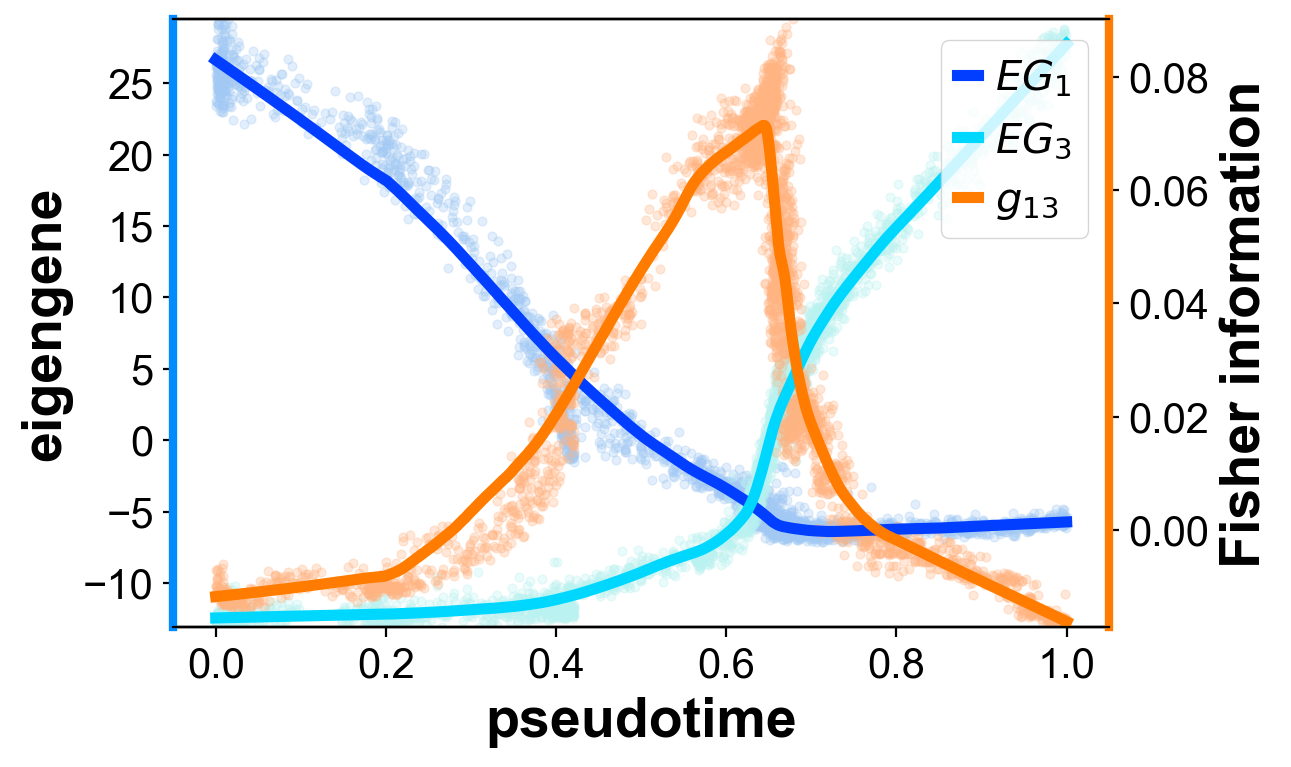

In [23]:
ei,ej = 0,1

# plt.figure(dpi=600,bbox_inches='tight')
mask1,x_ls1,y_ls1 = kde_lowess(cell_vpt,cell_eigen_X[:,ei])
plt.scatter(cell_vpt[mask1], cell_eigen_X[mask1,ei],s=10,c=palette2[0],alpha=alpha)
mask2,x_ls2,y_ls2 = kde_lowess(cell_vpt,cell_eigen_X[:,ej])
plt.scatter(cell_vpt[mask2], cell_eigen_X[mask2,ej],s=10,c=palette2[-1],alpha=alpha)
plt.xlabel('pseudotime',fontsize=20,weight='bold')
plt.ylabel('eigengene',fontsize=20,weight='bold')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ymin1 = min(np.concatenate(([cell_eigen_X[mask1,ei],cell_eigen_X[mask2,ej]])))
ymax1 = max(np.concatenate(([cell_eigen_X[mask1,ei],cell_eigen_X[mask2,ej]])))
plt.ylim(ymin1,ymax1)

plt.twinx()
mask3,x_ls3,y_ls3 = kde_lowess(cell_vpt,eigen_gij[:,ei,ej])
plt.scatter(cell_vpt[mask3],eigen_gij[mask3,ei,ej],s=10,c=palette2[1],alpha=alpha)
plt.yticks([])
ymin2 = min(eigen_gij[mask3,ei,ej])
ymax2 = max(eigen_gij[mask3,ei,ej])
plt.ylim(ymin2,ymax2)

plt.twinx()
# ln1 = plt.plot(x_ls1, y_ls1, linewidth=4,color=palette1[0],label='$EG_'+str(ei)+'$')
# ln2 = plt.plot(x_ls2, y_ls2, linewidth=4,color=palette1[-1],label='$EG_'+str(ej)+'$')
ln1 = plt.plot(x_ls1, y_ls1, linewidth=4,color=palette1[0],label='$EG_1$')
ln2 = plt.plot(x_ls2, y_ls2, linewidth=4,color=palette1[-1],label='$EG_3$')
plt.yticks([])
plt.ylim(ymin1,ymax1)

plt.twinx()
# ln3 = plt.plot(x_ls3, y_ls3, linewidth=4,color=palette1[1],label='$g_{'+str(ei)+str(ej)+'}$')
ln3 = plt.plot(x_ls3, y_ls3, linewidth=4,color=palette1[1],label='$g_{13}$')
plt.ylabel('Fisher information',fontsize=20,weight='bold')
plt.yticks(fontsize=15)
plt.ylim(ymin2,ymax2)

ax = plt.gca()
ax.spines['left'].set_color(c1)
ax.spines['right'].set_color(palette1[1])
ax.spines['left'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)
plt.legend(handles=ln1+ln2+ln3,fontsize=15)
#plt.savefig(figure_path+'3g.png',dpi=600,bbox_inches='tight')
plt.show()

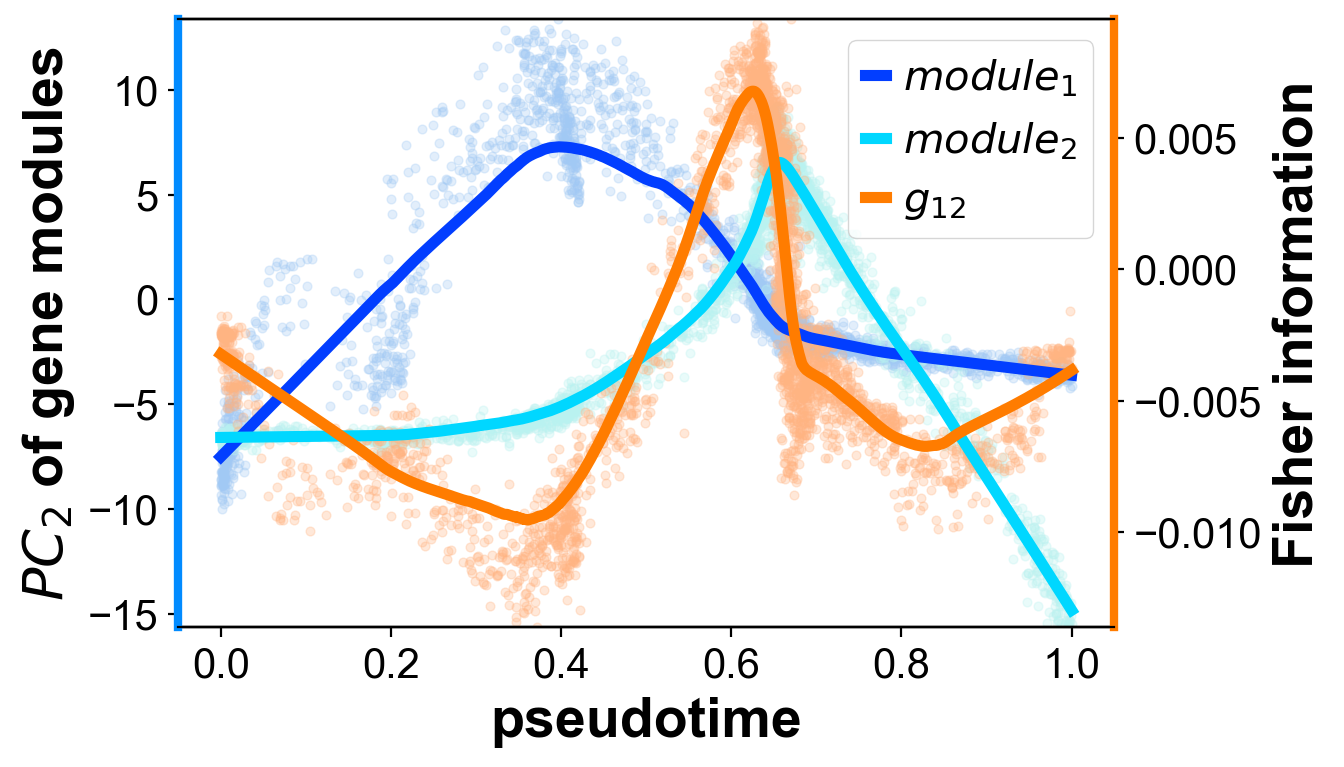

In [24]:
alpha = 0.3
frac = 0.1
ei,ej = 3,4

# plt.figure(dpi=600,bbox_inches='tight')
mask1,x_ls1,y_ls1 = kde_lowess(cell_vpt,cell_eigen_X[:,ei])
plt.scatter(cell_vpt[mask1], cell_eigen_X[mask1,ei],s=10,c=palette2[0],alpha=alpha)
mask2,x_ls2,y_ls2 = kde_lowess(cell_vpt,cell_eigen_X[:,ej])
plt.scatter(cell_vpt[mask2], cell_eigen_X[mask2,ej],s=10,c=palette2[-1],alpha=alpha)
plt.xlabel('pseudotime',fontsize=20,weight='bold')
plt.ylabel('$PC_2$ of gene modules',fontsize=20,weight='bold')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ymin1 = min(np.concatenate(([cell_eigen_X[mask1,ei],cell_eigen_X[mask2,ej]])))
ymax1 = max(np.concatenate(([cell_eigen_X[mask1,ei],cell_eigen_X[mask2,ej]])))
plt.ylim(ymin1,ymax1)

plt.twinx()
mask3,x_ls3,y_ls3 = kde_lowess(cell_vpt,eigen_gij[:,ei,ej])
plt.scatter(cell_vpt[mask3],eigen_gij[mask3,ei,ej],s=10,c=palette2[1],alpha=alpha)
plt.yticks([])
ymin2 = min(eigen_gij[mask3,ei,ej])
ymax2 = max(eigen_gij[mask3,ei,ej])
plt.ylim(ymin2,ymax2)

plt.twinx()
# ln1 = plt.plot(x_ls1, y_ls1, linewidth=4,color=palette1[0],label='$EG_'+str(ei)+'$')
# ln2 = plt.plot(x_ls2, y_ls2, linewidth=4,color=palette1[-1],label='$EG_'+str(ej)+'$')
ln1 = plt.plot(x_ls1, y_ls1, linewidth=4,color=palette1[0],label='$module_1$')
ln2 = plt.plot(x_ls2, y_ls2, linewidth=4,color=palette1[-1],label='$module_2$')
plt.yticks([])
plt.ylim(ymin1,ymax1)

plt.twinx()
# ln3 = plt.plot(x_ls3, y_ls3, linewidth=4,color=palette1[1],label='$g_{'+str(ei)+str(ej)+'}$')
ln3 = plt.plot(x_ls3, y_ls3, linewidth=4,color=palette1[1],label='$g_{12}$')
plt.ylabel('Fisher information',fontsize=20,weight='bold')
plt.yticks(fontsize=15)
plt.ylim(ymin2,ymax2)

ax = plt.gca()
ax.spines['left'].set_color(c1)
ax.spines['right'].set_color(palette1[1])
ax.spines['left'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)
plt.legend(handles=ln1+ln2+ln3,fontsize=15)
#plt.savefig(figure_path+'s2c.png',dpi=600,bbox_inches='tight')
plt.show()

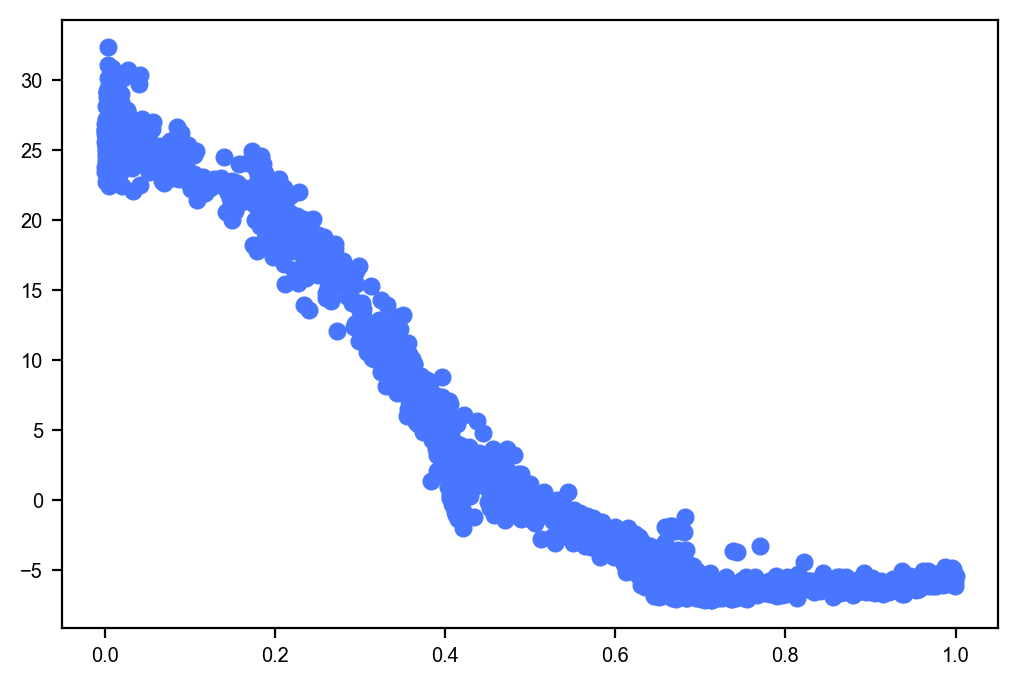

          Gene_set                                               Term Overlap  \
0  KEGG_2019_Mouse  Arrhythmogenic right ventricular cardiomyopath...    7/72   
1  KEGG_2019_Mouse           Glycine, serine and threonine metabolism    5/40   
2  KEGG_2019_Mouse                                    Prostate cancer    7/97   
3  KEGG_2019_Mouse             Bacterial invasion of epithelial cells    6/74   
4  KEGG_2019_Mouse                              Glutamatergic synapse   7/114   
5  KEGG_2019_Mouse                                Nitrogen metabolism    3/17   
6  KEGG_2019_Mouse                               Steroid biosynthesis    3/19   
7  KEGG_2019_Mouse                                  Adherens junction    5/72   
8  KEGG_2019_Mouse  Parathyroid hormone synthesis, secretion and a...   6/107   
9  KEGG_2019_Mouse                             Gastric acid secretion    5/74   

    P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0  0.000020          0.00416

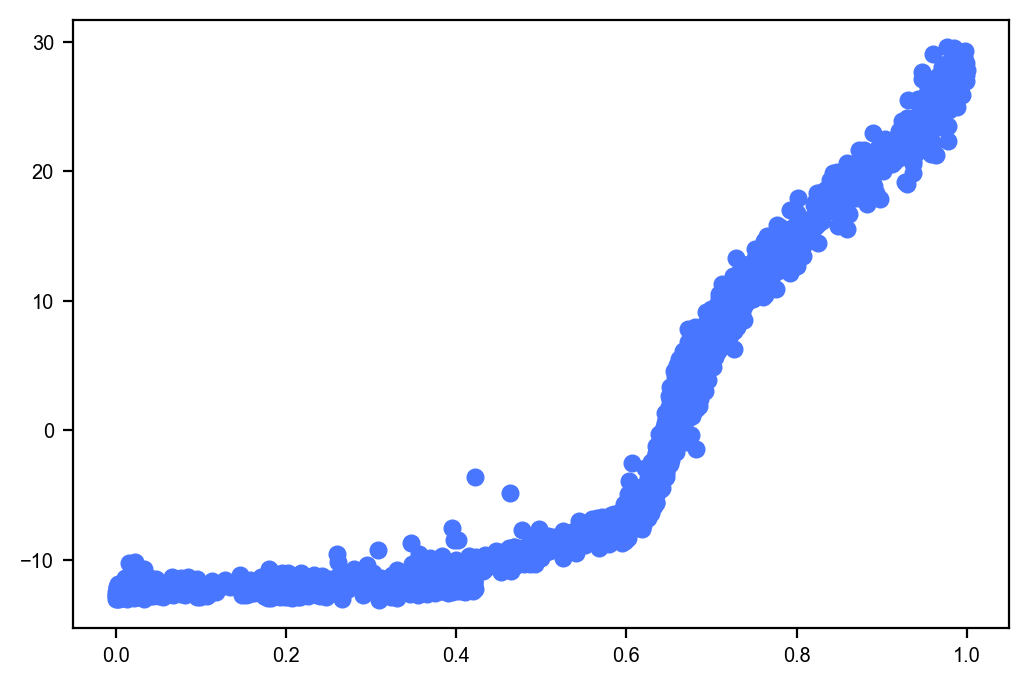

          Gene_set                                  Term Overlap  \
0  KEGG_2019_Mouse                         Axon guidance  15/180   
1  KEGG_2019_Mouse                    Nicotine addiction    8/40   
2  KEGG_2019_Mouse  Retrograde endocannabinoid signaling  13/150   
3  KEGG_2019_Mouse                 Glutamatergic synapse  11/114   
4  KEGG_2019_Mouse                    Morphine addiction   10/92   
5  KEGG_2019_Mouse                Long-term potentiation    8/67   
6  KEGG_2019_Mouse                     GABAergic synapse    9/90   
7  KEGG_2019_Mouse                   Cholinergic synapse   9/113   
8  KEGG_2019_Mouse                MAPK signaling pathway  14/294   
9  KEGG_2019_Mouse             Calcium signaling pathway  11/189   

        P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0  2.258916e-08          0.000004            0                     0   
1  5.113232e-08          0.000005            0                     0   
2  1.255186e-07          0.000008  

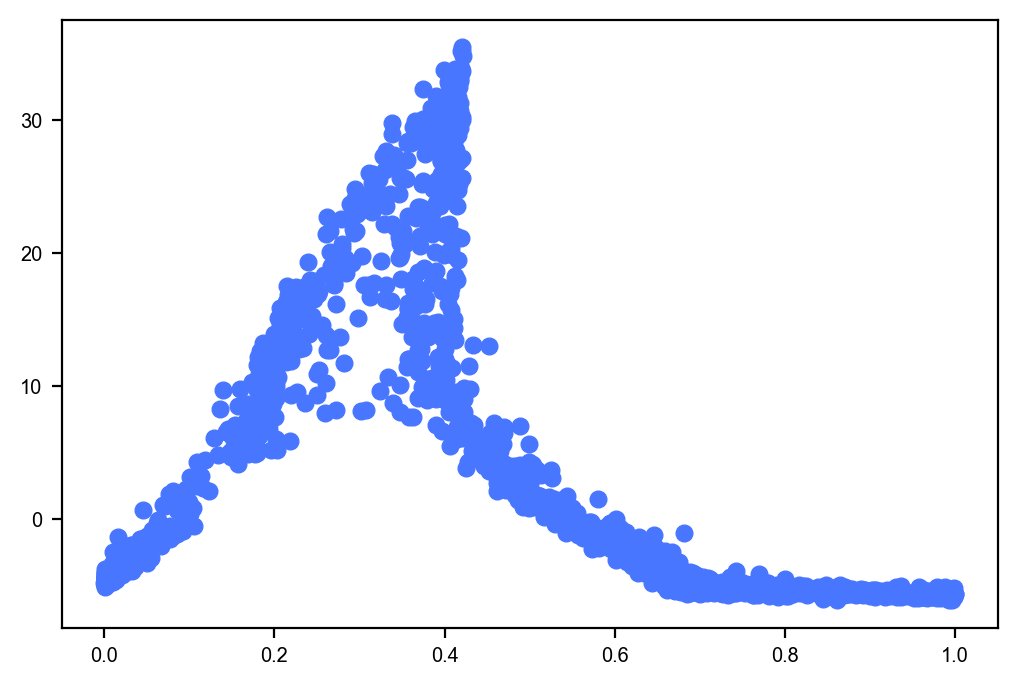

          Gene_set                                     Term Overlap  \
0  KEGG_2019_Mouse                          DNA replication   11/35   
1  KEGG_2019_Mouse                               Cell cycle  16/123   
2  KEGG_2019_Mouse                          Mismatch repair    6/22   
3  KEGG_2019_Mouse               Nucleotide excision repair    6/43   
4  KEGG_2019_Mouse                           Oocyte meiosis   7/116   
5  KEGG_2019_Mouse  Human T-cell leukemia virus 1 infection   9/245   
6  KEGG_2019_Mouse                    p53 signaling pathway    5/71   
7  KEGG_2019_Mouse                 Homologous recombination    4/41   
8  KEGG_2019_Mouse  Progesterone-mediated oocyte maturation    5/90   
9  KEGG_2019_Mouse                    Pyrimidine metabolism    4/58   

        P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0  6.612673e-15      6.149786e-13            0                     0   
1  1.482974e-14      6.895830e-13            0                     0   
2 

In [25]:
import gseapy as gp

enr = [0]*eigen_dim
for i in range(eigen_dim):
    enr[i] = gp.enrichr(gene_list=gene_arr[T==i+1].tolist(),
                         gene_sets='KEGG_2019_Mouse',
                         organism='Mouse', # don't forget to set organism to the one you desired! e.g. Yeast
                         # description='test_name',
                         outdir='test/enrichr_kegg',
                         # no_plot=True,
                         cutoff=0.5 # test dataset, use lower value from range(0,1)
                        )
    
    plt.scatter(cell_vpt,cell_eigen_X1[:,i])
    plt.show()
    print(enr[i].results.head(10))

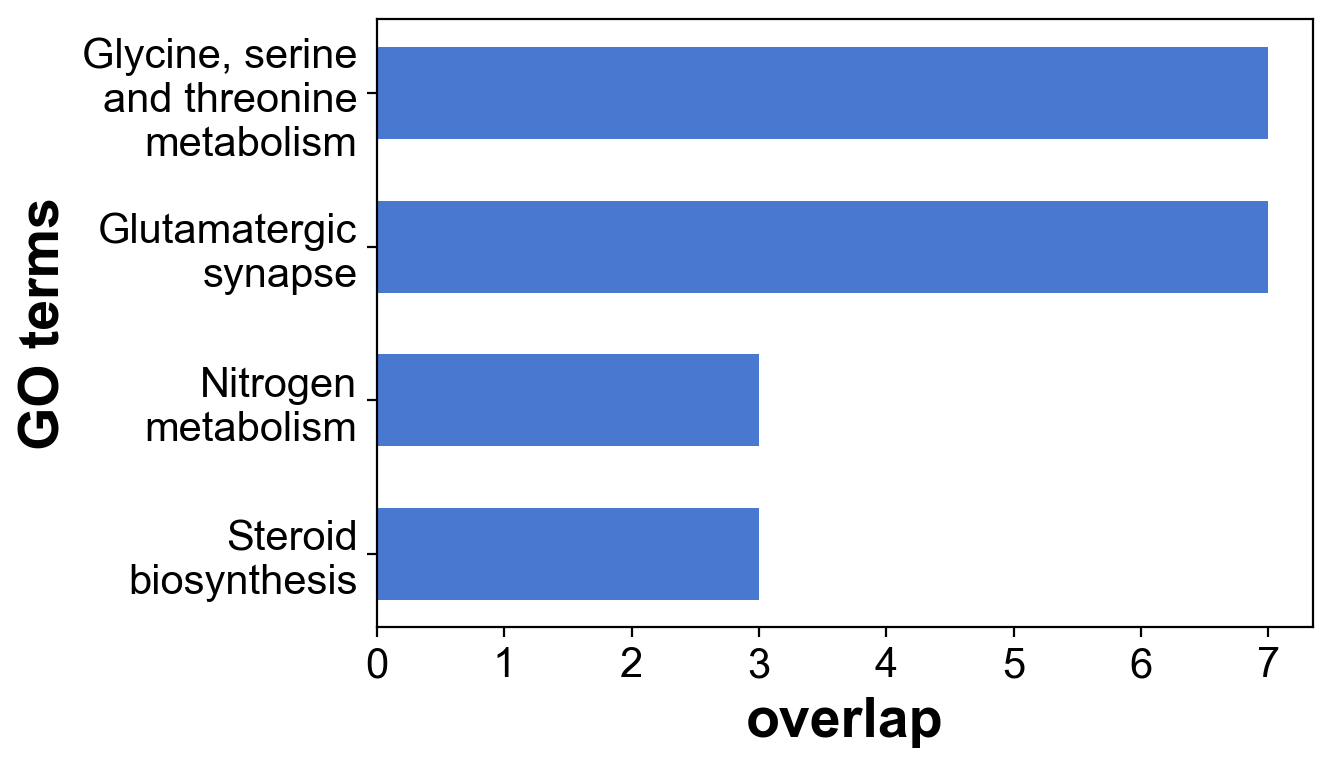

In [26]:
term = np.array(enr[0].results.head(20).Term[[1,4,5,6]])[::-1]
term[3] = 'Glycine, serine\nand threonine\nmetabolism'
term[2] = 'Glutamatergic\nsynapse'
term[1] = 'Nitrogen\nmetabolism'
term[0] = 'Steroid\nbiosynthesis'
overlap = [3,3,7,7]

plt.barh(term,overlap,height=0.6,color=sns.color_palette('muted')[0])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.legend(fontsize=15)
plt.xlabel('overlap',fontsize=20,weight='bold')
plt.ylabel('GO terms',fontsize=20,weight='bold')
# xt = np.linspace(0.9,1.1,6)
# plt.xticks(xt,label=xt)
#plt.savefig(figure_path+'dg_go_eg0.png',dpi=600,bbox_inches='tight')
plt.show()

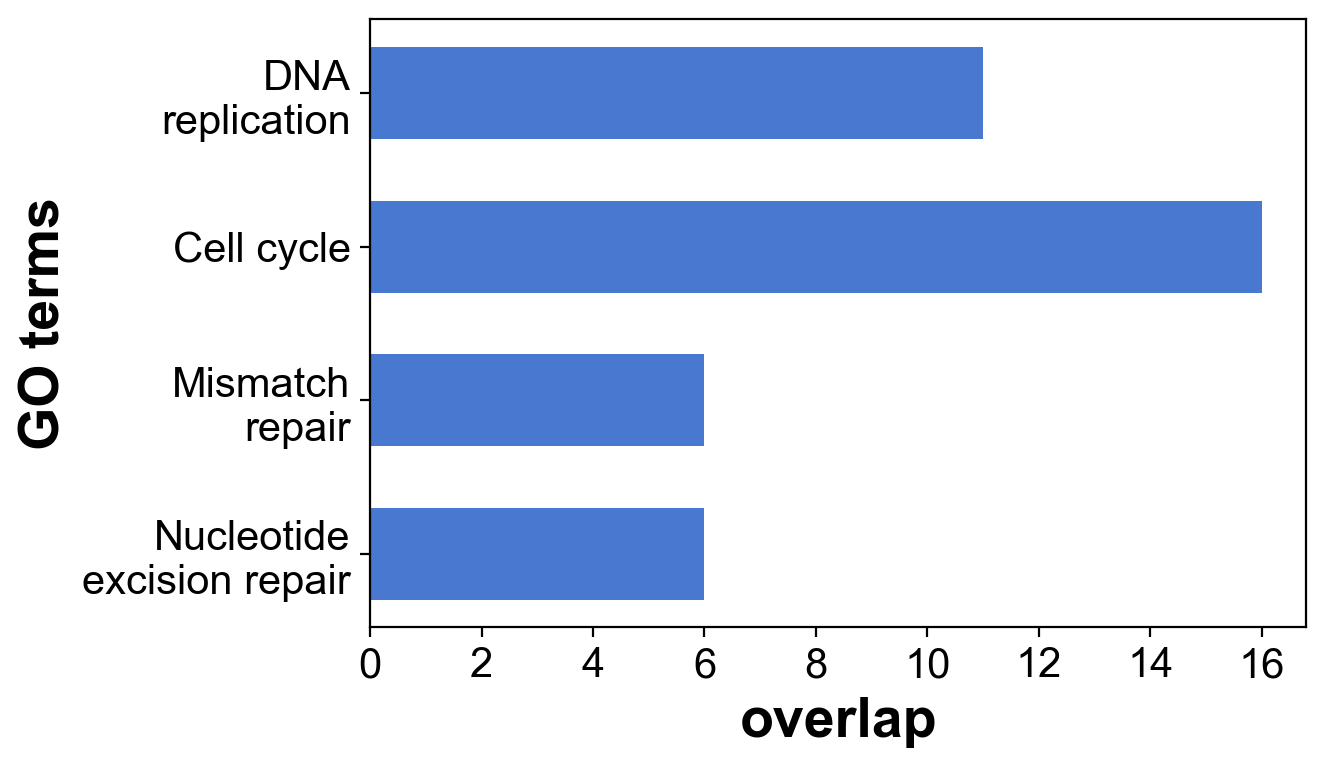

In [27]:
term = np.array(enr[2].results.head(20).Term[[0,1,2,3]])[::-1]
term[3] = 'DNA\nreplication'
term[1] = 'Mismatch\nrepair'
term[0] = 'Nucleotide\nexcision repair'
overlap = [6,6,16,11]

plt.barh(term,overlap,height=0.6,color=sns.color_palette('muted')[0])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.legend(fontsize=15)
plt.xlabel('overlap',fontsize=20,weight='bold')
plt.ylabel('GO terms',fontsize=20,weight='bold')
# xt = np.linspace(0.9,1.1,6)
# plt.xticks(xt,label=xt)
#plt.savefig(figure_path+'dg_go_eg1.png',dpi=600,bbox_inches='tight')
plt.show()

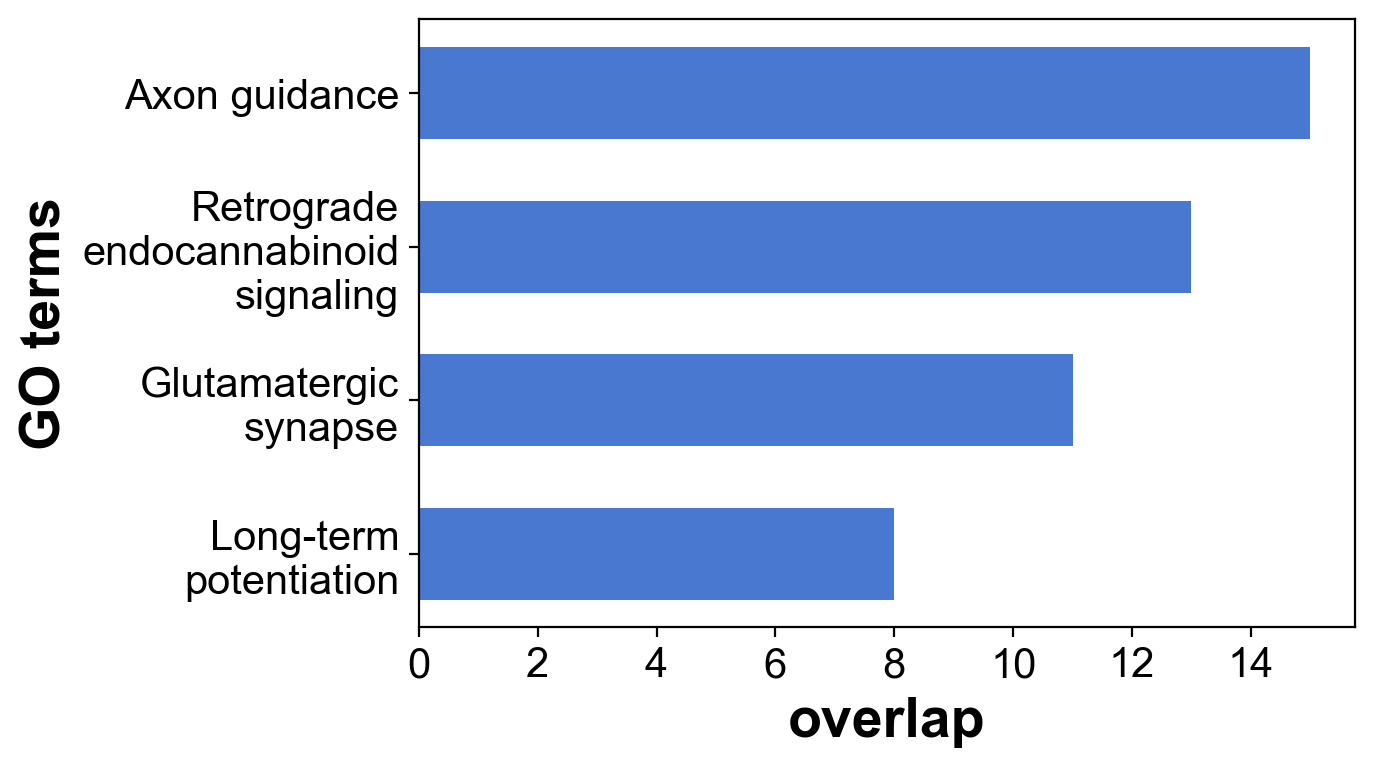

In [28]:
term = np.array(enr[1].results.head(20).Term[[0,2,3,5]])[::-1]
term[2] = 'Retrograde\nendocannabinoid\nsignaling'
term[1] = 'Glutamatergic\nsynapse'
term[0] = 'Long-term\npotentiation'
overlap = [8,11,13,15]

plt.barh(term,overlap,height=0.6,color=sns.color_palette('muted')[0])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.legend(fontsize=15)
plt.xlabel('overlap',fontsize=20,weight='bold')
plt.ylabel('GO terms',fontsize=20,weight='bold')
# xt = np.linspace(0.9,1.1,6)
# plt.xticks(xt,label=xt)
#plt.savefig(figure_path+'dg_go_eg2.png',dpi=600,bbox_inches='tight')
plt.show()